# Deep learning project: Ship recognition in sattelite images
Team members: 
* Csatlós Tamás Péter (cstompet@gmail.com)
* Kalapos András (kalapos.andras@gmail.com)

In this assignment we are going to recognise ships on satelite images of the surface of the oceans and seas. You can find the kaggle challenge [here](https://www.kaggle.com/c/airbus-ship-detection).

In [30]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from imageio import imread
import sklearn
from tqdm import tqdm_notebook
from prettytable import PrettyTable
from keras.utils import Sequence

## Exploring and visualizing the data 

In [16]:
df_train = pd.read_csv('data/train_ship_segmentations_v2.csv')
ep_train = df_train.EncodedPixels.values # get every masks
image_ids_train = df_train["ImageId"].values # get every image ID's for later

In [2]:
df_train = pd.read_csv('data/train_ship_segmentations_v2.csv')
print(df_train.describe())

              ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     cc8960db1.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2


In [3]:
df_train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Total number of masks (full dataset size = ships + images without ships):	 231723
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Total number of ships (number of non-empty masks):				 81723

Number of images:								 192556
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Number of images containing a ship:						 42556
   ↳Number of images containing multiple ships:					 15452


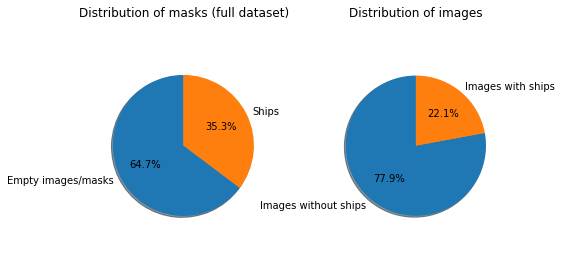

In [4]:
#Note for using  count() and size: size includes NaN values, count does not (https://stackoverflow.com/questions/33346591/what-is-the-difference-between-size-and-count-in-pandas)
#For counting rows of a dataframe we could use len(df.index) or df.shape[0] (the prior should be faster: https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe)

#Important note: if an image contains multiple ships separate masks are defined for each ship

# Number of masks - Size of the total dataset
n_masks = len(df_train.index)
print("Total number of masks (full dataset size = ships + images without ships):\t", n_masks)

# Number of empty masks - Number of empty images
n_empty_masks = len(df_train[df_train['EncodedPixels'].isnull()].index)
print(" ↳Number of images without ships (number of empty masks):\t\t\t", n_empty_masks)

# Number of not empty masks - Number of ships
n_ships = df_train.count()['EncodedPixels']
print(" ↳Total number of ships (number of non-empty masks):\t\t\t\t", n_ships)

# Number of images
n_images = df_train.nunique()['ImageId']
print("\nNumber of images:\t\t\t\t\t\t\t\t", n_images)

# Number of images without ships (number of empty masks)
n_im_wo_ship = df_train[df_train['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images without ships (number of empty masks):\t\t\t",n_im_wo_ship)

# Number of images containing a ship
n_im_with_ship = df_train[~df_train['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images containing a ship:\t\t\t\t\t\t", n_im_with_ship)

#Number of images containing multiple ships
n_im_multi_ship = df_train[df_train['ImageId'].duplicated()].nunique()['ImageId']
print("   ↳Number of images containing multiple ships:\t\t\t\t\t", n_im_multi_ship)

# Pie chart
#https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
labels = ['Empty images/masks', 'Ships']
sizes = [n_empty_masks, n_ships]
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of masks (full dataset)')
plt.tight_layout()

#Distribution of images
labels = ['Images without ships', 'Images with ships']
sizes = [n_im_wo_ship, n_im_with_ship]
plt.subplot(1,2,2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of images')
plt.tight_layout()

plt.subplots_adjust( wspace=0.5)

Number of ships per image:
count    192556.000000
mean          0.424412
std           1.199094
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: EncodedPixels, dtype: float64

Histogram of number of ships per image
+---------------------------+--------+
| Number of ships per image | Count  |
+---------------------------+--------+
|            0.0            | 150000 |
|            1.0            | 27104  |
|            2.0            |  7674  |
|            3.0            |  2954  |
|            4.0            |  1622  |
|            5.0            |  925   |
|            6.0            |  657   |
|            7.0            |  406   |
|            8.0            |  318   |
|            9.0            |  243   |
|            10.0           |  168   |
|            11.0           |  144   |
|            12.0           |  124   |
|            13.0           |   75   |
|            14.0           |   76   |
|          

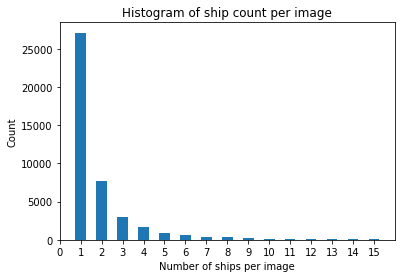

In [6]:
ship_per_img = df_train.groupby('ImageId').count().iloc[:,0]
print("Number of ships per image:")
print(ship_per_img.describe())

print("\nHistogram of number of ships per image")
[count, bins] = np.histogram(ship_per_img,bins=ship_per_img.max()+1,range=(0,ship_per_img.max()+1))
x = PrettyTable()
x.add_column("Number of ships per image",bins[:-1])
x.add_column("Count", count)
print(x)

plt.hist(ship_per_img,bins=ship_per_img.max(),range=(1,ship_per_img.max()+1),rwidth=0.5, align='left');
plt.xticks(np.arange(ship_per_img.min(), ship_per_img.max()+1, step=1));
plt.xlabel("Number of ships per image");
plt.ylabel("Count");
plt.title("Histogram of ship count per image");

Note: for better visiblity we removed the count of images whithout a ship from the histogram.

Conclusion: most of the images with ships contain only a few ships

In [7]:
# Reference: https://www.kaggle.com/inversion/run-length-decoding-quick-start
# mask_rle: run-length as string formated (start length)
# shape: (height,width) of array to return 
# Returns numpy array, 1 - ship 0 - background
# If mask_rle mask is nan, the returned numpy array only contains zeros
def rle_decode(mask_rle, shape=(768, 768)):
    # Create the all zero mask
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    if mask_rle == mask_rle: # if mask_rle is nan that this equality check returns false
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        
    return img.reshape(shape).T  # Needed to align to RLE direction

In [9]:
# calculate ship-noship ratio for each mask and sum for each mask
ShipSize = np.zeros(len(df_train.index))
pbar = tqdm_notebook(total=len(df_train.index))
for index, row in df_train.iterrows():
    mask = row['EncodedPixels']
    if mask == mask: #If mask is nan, mask == mask is returns false
        ShipSize[index] = np.sum(rle_decode(mask))/(768*768)
    pbar.update(1)
pbar.close()

pd.Series(ShipSize*100).describe()

count    231723.000000
mean          0.093720
std           0.313059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.022464
max           4.391819
dtype: float64

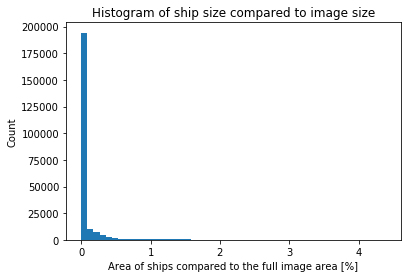

In [21]:
plt.hist(ShipSize*100,bins=50);
plt.xlabel("Area of ships compared to the full image area [%]");
plt.ylabel("Count");
plt.title("Histogram of ship size compared to image size");


Conclusion: Most of the ships are very small, smaller that 0.1% of an image.

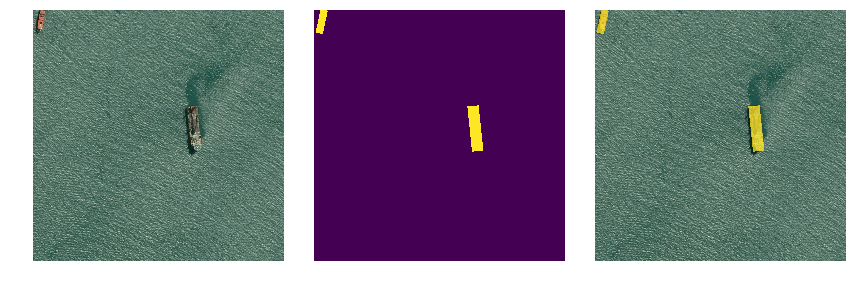

In [188]:
# Create a new colormap which ranges from 0 to 100% transparency
# Ref: https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
cmap = pl.cm.viridis
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

#Ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
img = imread('data/train_img/' + '0a2c6480e.jpg')
img_masks = df_train.loc[df_train['ImageId'] == '0a2c6480e.jpg', 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(12, 30))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.75, cmap=my_cmap)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

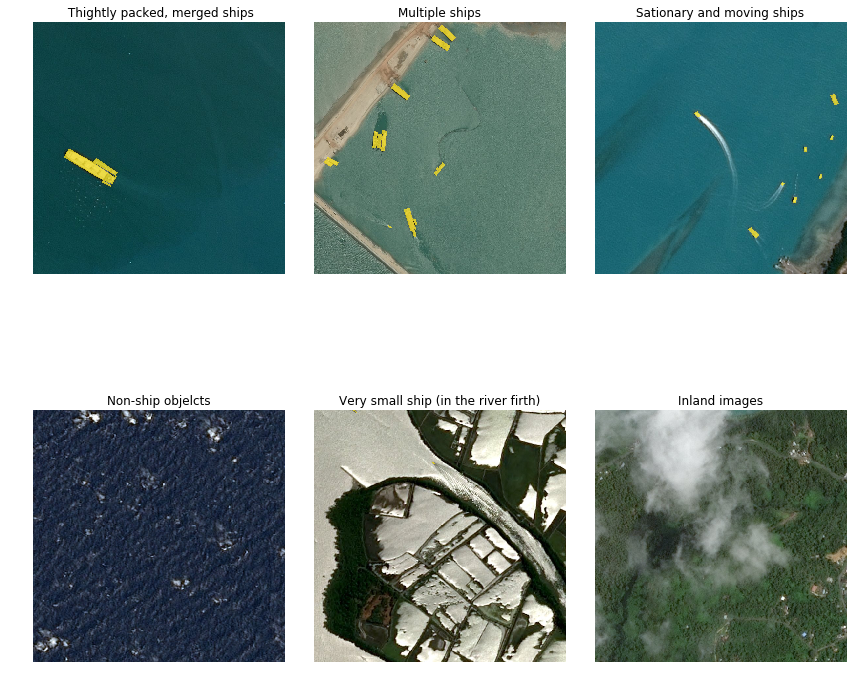

In [219]:
def DispImageWithMap(ImageId,im_title="",ax=plt):
    img = imread('data/train_img/' + ImageId)
    img_masks = df_train.loc[df_train['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
    
    ax.imshow(img)
    ax.imshow(all_masks, alpha=0.75, cmap=my_cmap)
    ax.axis('off')
    ax.set_title(im_title)


fig, axarr = plt.subplots(2, 3, figsize=(12,12))
DispImageWithMap('0a0df8299.jpg',im_title=" Thightly packed, merged ships", ax = axarr[0,0])
DispImageWithMap('0a1a7f395.jpg',im_title="Multiple ships", ax = axarr[0,1])
DispImageWithMap('0a2e15e29.jpg',im_title="Sationary and moving ships", ax = axarr[0,2])
DispImageWithMap('0a2f58d54.jpg',im_title="Non-ship objelcts", ax = axarr[1,0])
DispImageWithMap('0a4ad0982.jpg',im_title="Very small ship (in the river firth)", ax = axarr[1,1])
DispImageWithMap('0a3ab4644.jpg',im_title="Inland images",ax = axarr[1,2])

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()

## Preparing the data for learning 

To test the following functionalities we included only a small portion of the dataset in the forlder for the test images. The next cell filters the dataframe to only contain rows about these images.

In [200]:
## This cell is only necessary if not all the training image files are present in the images folder
import os

# This method takes ages
# for idx, img_file in tqdm_notebook(masks.iterrows()):
#     ImageId = img_file["ImageId"]
#     if ~os.path.isfile('data/images'+ImageId): 
#         masksdf=masksdf[masksdf.ImageId!=ImageId]

img_files = os.listdir('data/train_img')

df_train['img_found'] = False
for img_file in img_files:
    df_train['img_found'] = (df_train['img_found']) | (df_train['ImageId']==img_file)
df_train = df_train[df_train['img_found']]
df_train = df_train.drop('img_found',axis = 1)

df_train = df_train.reset_index(drop=True)

In [227]:
def min_max(img_matrix, min=0, max=1):
    return img_matrix/255.0 * (max - min) + min

def separate(train_data, valid_split=0.2, train_split=0.2):
    """
    
    Separate the dataset into 3 different part. Train, validation and test.
    train_data and test_data sets are 1D numpy arrays.

    returns the train, valid and test data sets
    
    """
    
    sum_ = train_data.shape[0]
    train = None
    valid = None
    test = None
    
    train = train_data[:int(sum_*(1-valid_split-test_split))]
    valid = train_data[int(sum_*(1-valid_split-test_split)):int(sum_*(1-test_split))]
    test = train_data[int(sum_*(1-test_split)):]
       
    return train, valid, test

def read_transform_image(img_file_path):
    img = mpimg.imread(img_file_path)
    #print(img)
    return min_max(img)


def DispImageWithMap(img_matrix, mask_matrix):
    plt.imshow(img_matrix)
    plt.imshow(mask_matrix, alpha=0.75, cmap=my_cmap)
    plt.axis('off')
    plt.show()

In [228]:
# Testing min_max separate
img = imread('data/train_img/' + '0a0df8299.jpg')
print("Image data shape and type:", img.shape, img.dtype)
print("Image data min and max: ", img.min(), img.max())
mm_img = min_max(img, min=-1, max=1)
print("Image data shape and type:", mm_img.shape, mm_img.dtype)
print("Image data min and max: ", mm_img.min(), mm_img.max())

Image data shape and type: (768, 768, 3) uint8
Image data min and max:  0 235
Image data shape and type: (768, 768, 3) float64
Image data min and max:  -1.0 0.8431372549019607


Sum: 231723
Expected results:
Train: 162206, Valid: 34758, Test: 34758


Sum : 231723
Result train data:
Train: 162206, Result valid data: 34758, Result test data: 34759




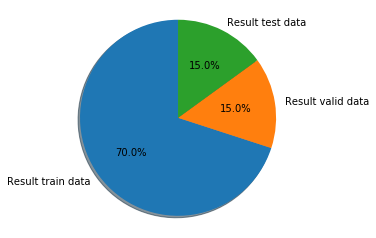

In [229]:
#Testing split
valid_split = 0.15
test_split = 0.15

sum_ = image_ids_train.shape[0]
trn = int(sum_ * (1-valid_split-test_split))
van = int(sum_ * valid_split)
ten = int(sum_ * test_split)

print("Sum: {}".format(sum_))
print(
    "Expected results:\nTrain: {}, Valid: {}, Test: {}\n\n"
    .format(trn, van, ten)
)

train, valid, test = separate(image_ids_train, valid_split, test_split)

sum_ = train.shape[0] + valid.shape[0] + test.shape[0]
trn = train.shape[0]
van = valid.shape[0]
ten = test.shape[0]

print("Sum : {}".format(sum_))
print(
    "Result train data:\nTrain: {}, Result valid data: {}, Result test data: {}\n\n"
    .format(trn, van, ten)
)

labels2 = "Result train data", "Result valid data", "Result test data"
sizes2 = [trn, van, ten]

plt.pie(sizes2, labels=labels2, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') 

plt.show()

### Keras data generator 

A data generator is used to load and process images during training. The dataset is too large to be loaded and porcessed onced, by using a data generator only a small portion of the imagies is loaded at a time. The downside of this approach is that images are reloaded and tranformed again again in every epoch. 

In [230]:
# Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    
    def __init__(self, list_IDs, labels, img_path_prefix, batch_size=32, dim=(32,32,32),
                 n_channels=1, n_classes=10, shuffle=True):
        #Initialization
        self.dim = dim                              # dataset's dimension
        self.img_prefix = img_path_prefix           # location of the dataset
        self.batch_size = batch_size                # number of data/epoch
        self.labels = labels                        # "img":"rle mask" dictionary
        self.list_IDs = list_IDs                    # images filenames 
        self.n_channels = n_channels                # number of rgb chanels
        #self.n_classes = n_classes                 # ???
        self.shuffle = shuffle                      # shuffle the data
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        #Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        print("Ep end: {0}".format(self.indexes))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        #Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
      
    def __getitem__(self, index):
        # Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        print("getitem: {}".format(self.indexes))
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        print("getitem: {}".format(list_IDs_temp))
        
        # Generate data
        X, Y = self.generate(list_IDs_temp)

        return X, Y

    def generate(self, tmp_list):
        #Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.dim))
        #print(X.shape)
        #print(X)

        # Generate data
        for i, ID in enumerate(tmp_list):
            # read image called "ID"
            X[i] = read_transform_image(self.img_prefix+"/"+ID)
            
            #print("\n\n{}\n\n".format(X[i]))
            
            # store masks
            mask = rle_decode(labels[ID][0])
            Y[i] = mask

        return X, Y

#### Testing the DataGenerator

Ep end: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]
Ep end: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
getitem: [60 53 33 10 21 87 31  8 38 49 11 96 32  5 65 73 43 14 13 61 89 44 50 66
 97 69 58 30 23  9 85 40 46 55 82 81 62 86 77 83 12 26 34  3 72 88  0 39
 25 95 78 68  7 70 79 51 67 92 15 54 45 19 57 29 74 93 28 20 24 84  1 75
 47 48 56 52 35 18 76 27  4 22 37  6 80 59  2 16 91 36 64 90 94 17 42 71
 41 63]
getitem: ['0a1a7f395.jpg', '0a0cdca85.jpg', '0a0c7f8d1.jpg', '0a1d5d8c1.jpg']

Results are: 

(2, 768, 768, 3)
(2, 768, 768)


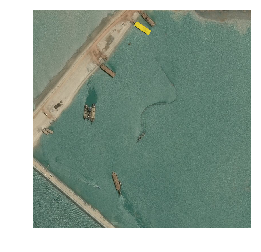

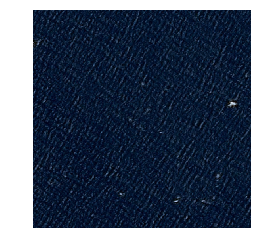

In [238]:
valid_split = 0.15
X_debug_train = df_train['ImageId'].values
img_train, img_valid,img_test = separate(X_debug_train, valid_split)

# dictionaries for the generators
partitions = {"train": img_train, "validation": img_valid}
# {"imgID1" : rle mask1, "imgID2" : rle_mask1, ... }  
labels = dict()

for i in range(X_debug_train.shape[0]):
    labels[X_debug_train[i]] = df_train.loc[df_train.ImageId == X_debug_train[i]].EncodedPixels.values
    
#print(labels[X_debug_train[5]][0])  # has rle mask
#print(labels[X_debug_train[12]][0]) # doesn't have rle mask

# ezeket majd a model.fit_generatot(...) függvényének adjuk át
rgb_channels_number = 3
dimension_of_the_image = (768, 768)
how_many_pictures_needed_per_epoch = 4

training_generator = DataGenerator(
    partitions["train"],
    labels,
    "data/train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)

validation_generator = DataGenerator(
    partitions["validation"],
    labels,
    "data/train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)

gen_img, gen_mask = training_generator.__getitem__(4)
print("\nResults are: \n")
print(result[0].shape)
print(result[1].shape)

# print(result[0][1]*255)
# plt.imshow(result[0][1])
DispImageWithMap(gen_img[0],gen_mask[0])
DispImageWithMap(gen_img[1],gen_mask[1])

### Data augmentation

Though the dataset might seem large, data autmentation might still improve results, if we can afford the additional training time. Thus we implement two types of data augmentation: rotation (by +-90, 180 degrees) and mirroring. These operations shouldn't introduce false or incorrect training examples. The two transformations combined can introduce 8 different versions of the same imag. (see all possibilities below). It can be easily shown that the maximum 8 different versions can be produced using rotations and flips. 

!!!!!!!!!!!!!!Ebben a cikkben a cikkben azt írják a 4.2 pontban, hogy At training time, for each batch, additional training instances are generated by applying rotation or mirroring randomly. Szóval lehet elég random  is.

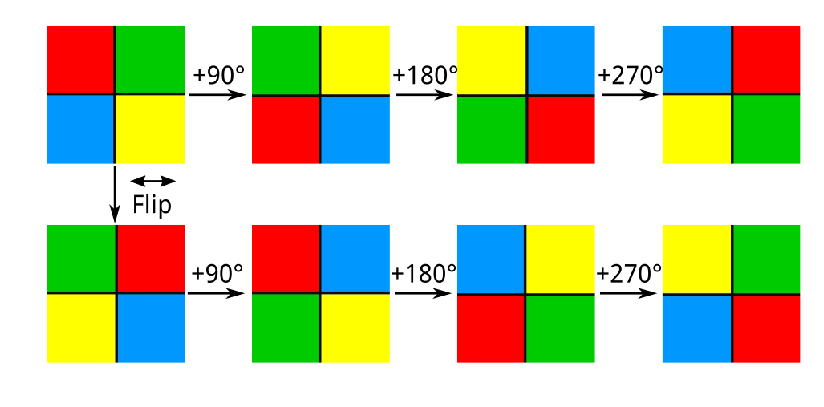

In [138]:
plt.figure(figsize=(14,30))
plt.imshow(imread('Transformations.png'));
plt.axis('off');

In [101]:
def augmentData(df_data, useFlip=True, useRot=True):
    df_augmented = pd.DataFrame()
    if useRot:
        for angle in (0,90,180,270):
            df_temp = df_data.copy()
            df_temp['Rot'] = angle
            df_augmented = df_augmented.append(df_temp)
    if useFlip:
        df_augmented['Flip'] = False
        df_temp = df_augmented.copy()
        df_temp['Flip'] = True
        df_augmented = df_augmented.append(df_temp)
    return df_augmented

def transformData(img, mask, Rot=0, Flip=False):
    pass 

In [108]:
aug_df_train = augmentData(df_train)
aug_df_train.head()

,ImageId,EncodedPixels,Rot,Flip
0,00003e153.jpg,NaN,0,False
1,0001124c7.jpg,NaN,0,False
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,0,False
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,0,False
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,0,False


In [123]:
# Test code for accessing when iterating through a dataframe
for row in aug_df_train.iloc[1:2].itertuples():
    print(row.Rot, row.Flip)
    
for row in aug_df_train.iloc[1:2].iterrows():
    print(row[1].Rot, row[1].Flip)

0 False
0 False
